#データ準備

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pwd
%cd /content/drive/My Drive/Colab Notebooks/NLP

/content
/content/drive/My Drive/Colab Notebooks/NLP


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
!pip install mecab-python3
!pip install unidic-lite
import MeCab

     |████████████████████████████████| 488 kB 5.3 MB/s 
     |████████████████████████████████| 47.4 MB 53 kB/s 
  Created wheel for unidic-lite: filename=unidic_lite-1.0.8-py3-none-any.whl size=47658836 sha256=4a9796e11fc9f10259a36ad557a5fb8edea82105cceb2a3cb4004fd9d5e1153a
  Stored in directory: /root/.cache/pip/wheels/de/69/b1/112140b599f2b13f609d485a99e357ba68df194d2079c5b1a2
Successfully built unidic-lite


In [6]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
SOS_token = 0 #文頭マークを予約
EOS_token = 1 #文末マークを予約

class Lang:
    #+
    #言語ごとに、単語からIndex,Indexから単語へ変換する辞書を準備
    #-
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1


#+
#英語に関しては、全小文字にして、その他特殊文字を無視するように正規化
#-
def normalizeString(s):
    s = s.lower().strip()
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def readLangs(lang1,lang2,reverse=False):
    print("Reading lines...")
    tagger = MeCab.Tagger("-Owakati")
    lines = open('jpn.txt', encoding='utf-8').read().strip().split('\n') #jpn.txtに、英語、日本語のペアが入っている
    # 英語文は文字を正規化、日本語文は分かち書きして、ペアを作る
    pairs = [[normalizeString(l.split('\t')[0]), (tagger.parse(l.split('\t')[1])).replace('\n','')] for l in lines]
    print(pairs[:5])

    # ソースとターゲットを逆にしたいときのため
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
    return input_lang, output_lang, pairs

#+
#データが多いと語彙数が増えて負荷が大きいので、10単語以下で、かつ以下のパターンを持つ英文を含む行だけにフィルターする
#-
MAX_LENGTH = 10
eng_prefixes = ("i am ", "i m ", "he is", "he s ", "she is", "she s ", "you are", "you re ", "we are", "we re ",  "they are", "they re ")
def filterPairs(pairs, reverse):
    def filterPair(p, reverse):
      if reverse:
        return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH and p[1].startswith(eng_prefixes)
      else:
        return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH and p[0].startswith(eng_prefixes)
    return [pair for pair in pairs if filterPair(pair, reverse)]

#+
#ファイルからデータを読み込み、フィルターし、input_lang,output_langにそれぞれ格納する
#-
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs, reverse)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'jpn', False)
print(random.choice(pairs))
print(pairs[:5])

Reading lines...
[['go .', '行け 。 '], ['go .', '行き なさい 。 '], ['hi .', 'こんにちは 。 '], ['hi .', 'もしもし 。 '], ['hi .', 'やっほー 。 ']]
Read 48955 sentence pairs
Trimmed to 2081 sentence pairs
Counting words...
Counted words:
eng 1227
jpn 1561
['she is likely to come .', '彼女 は 来る だろう 。 ']
[['i m .', '１９ 歳 です 。 '], ['i m ok .', '大丈夫 です よ 。 '], ['i m ok .', '私 は 大丈夫 です 。 '], ['i m up .', '起き てる よ 。 '], ['i m tom .', 'トム と 申し ます 。 ']]


#Seq2Seq With Attention

In [8]:
#+
#入力文をGRUで符号化する
#-
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)  #単語の埋め込み表を作る
        self.gru = nn.GRU(hidden_size, hidden_size) #GRUオブジェクトを生成する

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1) #入力単語の埋め込みベクトルを取り出す
        output, hidden = self.gru(embedded, hidden) #GRUに通す
        return output, hidden #新しい隠れ状態を返す

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

#+
#入力文をGRUで符号化した結果（最終隠れ状態）と各出力に対し、Attentionを使って、出力単語列に復元する
#-
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length #このサイズのベクトルに、次単語予測時に、エンコーダー出力のどこに注目すればいいかを搭載する
        self.embedding = nn.Embedding(self.output_size, self.hidden_size) #埋め込み表を準備する、埋め込みと隠れベクトルは同サイズ
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length) #入力と隠れ状態から、最大単語数サイズへの、全結合
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size) #入力と重み適用結果から、隠れベクトルサイズへの、全結合
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size) #GRUオブジェクトを作る
        self.out = nn.Linear(self.hidden_size, self.output_size) #GRUの出力を出力言語語彙数サイズのベクトルへ全結合

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1) #単語の埋め込みベクトルを得る
        
        #
        embedded = self.dropout(embedded)
        attn = self.attn(torch.cat((embedded[0], hidden[0]), 1)) #入力と隠れ状態を連結し、全結合で、最大単語数サイズへ
        attn_weights = F.softmax(attn, dim=1) #Softmaxし、注目重みとする。shape(1,最大単語数10)
        #encoder_outputsは、時刻ごとの出力が縦（列）に、埋め込みベクトルが横（行）に並んでいる。shape(最大単語数10,埋め込みサイズ256)
        #重みとエンコーダー出力を掛け合わせる。(1x10)のベクトル＊(10x256)の行列->(1x256)のベクトル、どのエンコーダー出力に注目すべきかの重みづけの結果
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0)) #bmmは行列の掛け算

        #
        output = torch.cat((embedded[0], attn_applied[0]), 1) #入力と、重みづけをかけた結果を連結
        output = F.relu(self.attn_combine(output).unsqueeze(0)) #入力と重みづけをかけた結果を、隠れ状態サイズへ全結合
        output, hidden = self.gru(output, hidden) #注目重みを加味した入力を、GRUに通して、出力（次単語予測）を得る
        output = F.log_softmax(self.out(output[0]), dim=1) #全結合で出力言語語彙数サイズのベクトルへ変換し、softmax
        return output, hidden, attn_weights #次単語予測（次回は入力となる）と、隠れ状態とを返す、atn_weightsは表示したいためで、後続の処理では利用しない

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


In [9]:
#+
#文を単語IDリストにする
#-
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

#-
#文を、単語の並びのテンソルにする
#-
def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token) #文末マークを付加する
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1) #(単語数,1)のshapeにしてテンソル化

#+
#入力文とターゲット文をそれぞれ、単語を並べたテンソルにする
#-
def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0]) #入力文をshape(単語数,1)の行列にする  
    target_tensor = tensorFromSentence(output_lang, pair[1]) #ターゲット文をshape(単語数,1)の行列にする 
    return (input_tensor, target_tensor)

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden() #エンコーダーの隠れ状態を初期化
    encoder_optimizer.zero_grad() #エンコーダーの勾配を初期化
    decoder_optimizer.zero_grad() #デコーダーの勾配を初期化
    input_length = input_tensor.size(0) #入力単語数をとる
    target_length = target_tensor.size(0) #ターゲット単語数をとる
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)  #エンコーダーの出力を初期化
    loss = 0

    for ei in range(input_length): #入力単語数だけエンコーダーを回す
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]  #各出力（単語埋め込みサイズ）を保存、それぞれ各入力単語の情報を最も含む
    
    decoder_input = torch.tensor([[SOS_token]], device=device) #デコーダーの最初の入力を文頭マークにする
    decoder_hidden = encoder_hidden #エンコーダーの最終隠れ状態を、デコーダーの隠れ状態の初期値とする
    for di in range(target_length): #デコーダーを出力単語数だけ回す
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)  #デコーダーに通す。エンコーダーの出力を束ねて渡す
        loss += criterion(decoder_output, target_tensor[di]) #正解単語と比べてロスを計算する
        topv, topi = decoder_output.topk(1) #予測単語を得る
        decoder_input = topi.squeeze().detach()  #予測単語IDを取り出す
        if decoder_input.item() == EOS_token: break #予測単語が文末ならループを出る
    loss.backward() #逆伝播
    encoder_optimizer.step() #学習レートを調整
    decoder_optimizer.step() #学習レートを調整
    return loss.item() / target_length #平均ロスを返す

def trainIters(encoder, decoder, n_iters, print_every=1000, every=1000):
    loss_total = 0 
    training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]  #トレーニングデータを取り出す
    criterion = nn.NLLLoss() #ロスをクロスエントロピーに設定

    for iter in range(1, n_iters + 1): #n_itersだけトレーニングを回す
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0] #入力文の単語列、shape(単語数,1)
        target_tensor = training_pair[1] #ターゲット文の単語列、shape(単語数,1)
        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        loss_total += loss
        if iter % every == 0:
            loss_avg = loss_total / every
            loss_total = 0
            print('(%d %d%%) %.4f' % (iter, iter / n_iters * 100, loss_avg))

hidden_size = 256
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device) #エンコーダーオブジェクト作成
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device) #デコーダーオブジェクト作成
learning_rate=0.01
encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate) #SGDオプティマイザーオブジェクト作成
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate) #SGDオプティマイザーオブジェクト作成
trainIters(encoder, decoder, 50000) #trainItersを起動
#トレーニングに時間がかかるので終了したらいったん保存。
torch.save({
            'enc': encoder.state_dict(),
            'dec': decoder.state_dict(),
            'eopt': encoder_optimizer.state_dict(),
            'dopt': decoder_optimizer.state_dict(),
            }, 'seq2seq_a.pt')

(1000 2%) 3.5990
(2000 4%) 3.3181
(3000 6%) 3.1662
(4000 8%) 3.0307
(5000 10%) 2.9360
(6000 12%) 2.7458
(7000 14%) 2.5874
(8000 16%) 2.4786
(9000 18%) 2.2568
(10000 20%) 2.1014
(11000 22%) 1.9761
(12000 24%) 1.7931
(13000 26%) 1.6748
(14000 28%) 1.5975
(15000 30%) 1.4671
(16000 32%) 1.3489
(17000 34%) 1.2783
(18000 36%) 1.1947
(19000 38%) 1.1456
(20000 40%) 0.9958
(21000 42%) 0.9821
(22000 44%) 0.8472
(23000 46%) 0.8348
(24000 48%) 0.7838
(25000 50%) 0.7596
(26000 52%) 0.6373
(27000 54%) 0.6212
(28000 56%) 0.5882
(29000 57%) 0.5479
(30000 60%) 0.5551
(31000 62%) 0.5174
(32000 64%) 0.4873
(33000 66%) 0.4587
(34000 68%) 0.4660
(35000 70%) 0.4594
(36000 72%) 0.4063
(37000 74%) 0.4206
(38000 76%) 0.4167
(39000 78%) 0.4358
(40000 80%) 0.3979
(41000 82%) 0.3663
(42000 84%) 0.3629
(43000 86%) 0.4019
(44000 88%) 0.3489
(45000 90%) 0.3396
(46000 92%) 0.3363
(47000 94%) 0.3534
(48000 96%) 0.3341
(49000 98%) 0.3316
(50000 100%) 0.3154


> i m sorry to interrupt you .
= お 話 中 失礼 し ます 。 


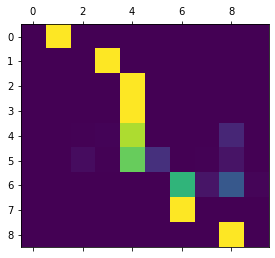

< お 話 中 失礼 し ます 。  <EOS>

> i m very busy .
= 大変 、 忙しい です 。 


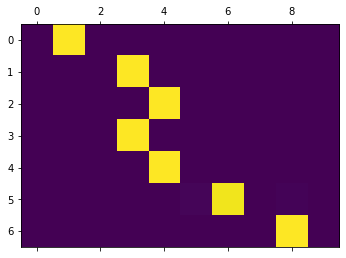

< 私 、 忙しい ほど 。  <EOS>

> he is afraid of his own shadow .
= 彼 は びくびく し て いる 。 


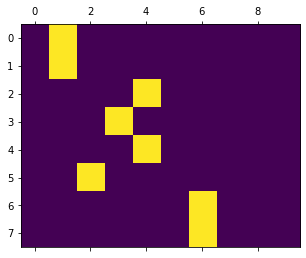

< 彼 は ひどく 臆病 て 。 。 <EOS>

> he is hated .
= 彼 は ひどく 嫌わ れ て いる 。 


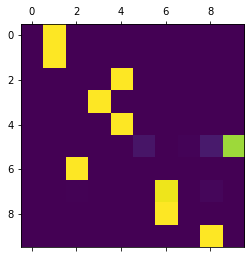

< 彼 は ひどく 嫌わ れ て いる 。  <EOS>

> i am a citizen of the world .
= 私 は 世界 市民 で ある 。 


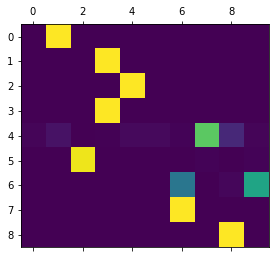

< 私 は 世界 市民 で ある 。  <EOS>

> he is a most important person .
= 彼 は 大変 重要 な 人物 です 。 


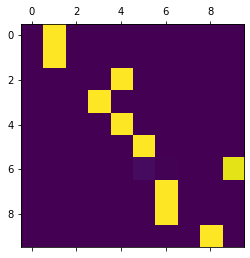

< 彼 は 大変 重要 な 人物 です 。  <EOS>

> he is just an ordinary person .
= 彼 は まったく 平凡 な 男 だ 。 


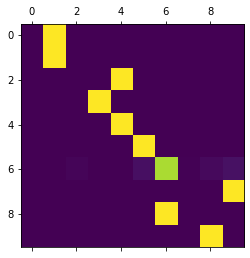

< 彼 は まったく 平凡 な 男 だ 。  <EOS>

> i m feeling a bit hungry .
= 少し お腹 が 空い て いる 。 


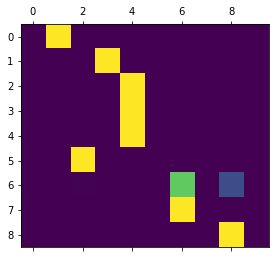

< 少し お腹 が 空い て いる 。  <EOS>

> she s a professional photographer .
= 彼女 は 写真 家 だ 。 


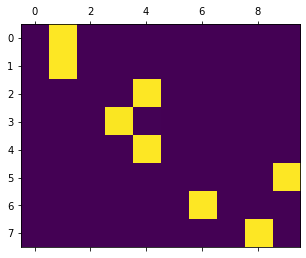

< 彼女 は 写真 家 だ 。  <EOS>

> she is in a bad mood .
= 彼女 は 機嫌 が 悪い 。 


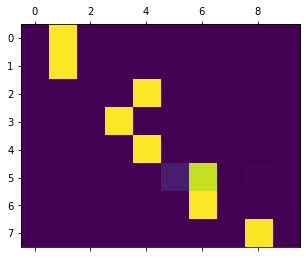

< 彼女 は 機嫌 が 悪い 。  <EOS>

> he is always punctual .
= 彼 は いつ も 時間 を 守る 。 


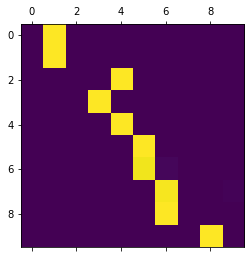

< 彼 は いつ も 時間 を 守る 。  <EOS>

> she is a reliable person .
= 彼女 は 信頼 できる 人 だ 。 


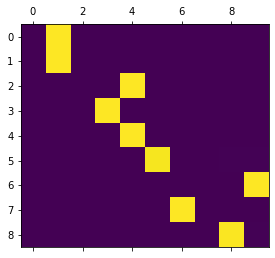

< 彼女 は 信頼 できる 人 だ 。  <EOS>

> i m busy now .
= 今 、 忙しい の 。 


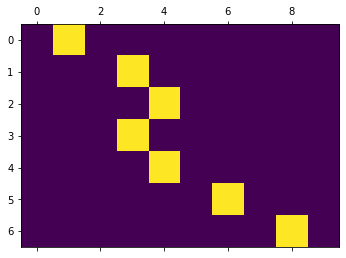

< 今 、 忙しい が 。  <EOS>

> she is afraid of her own shadow .
= 彼女 は とても 臆病 だ 。 


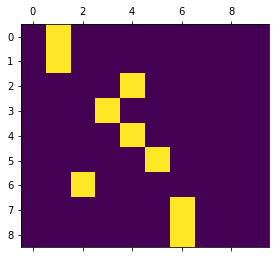

< 彼女 は 自分 の 影 に 。 。 <EOS>

> i m hungover .
= 二 日 酔い だ 。 


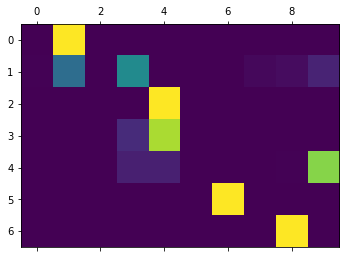

< 二 日 酔い だ 。  <EOS>

> you re bad .
= 悪い 子 ね ！ 


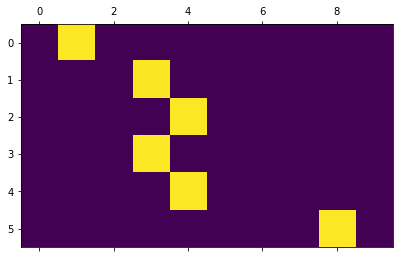

< 悪い 、 悪い ！  <EOS>

> i m sorry you lost .
= 試合 、 残念 だっ た ね 。 


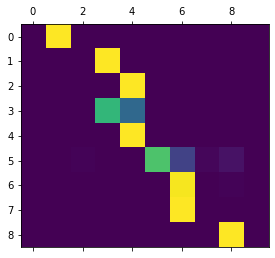

< 試合 、 残念 だっ た ね 。  <EOS>

> you re welcome .
= どう 致し まし て 。 


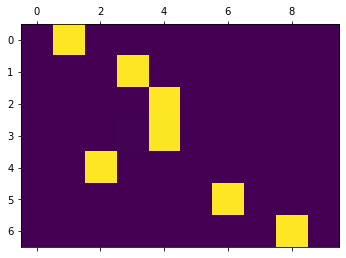

< どう 致し まし て 。  <EOS>

> he s now on the phone .
= 彼 は 今 電話 中 です 。 


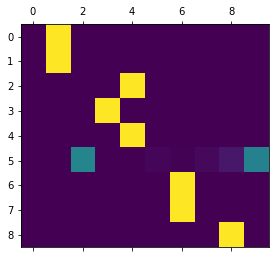

< 彼 は 今 電話 中 です 。  <EOS>

> i m looking forward to tomorrow night .
= 明日 の 夜 が 待ち遠しい です 。 


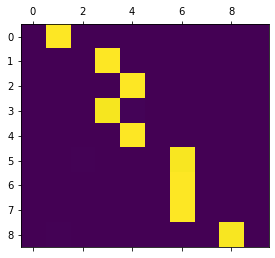

< 明日 の 夜 が 待ち遠しい です 。  <EOS>

> i m just joking .
= 冗談 です よ 。 


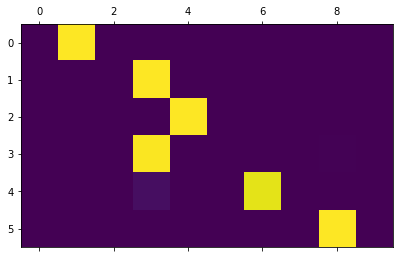

< 冗談 です よ 。  <EOS>

> she is a beginner .
= 彼女 は 初心 者 だ 。 


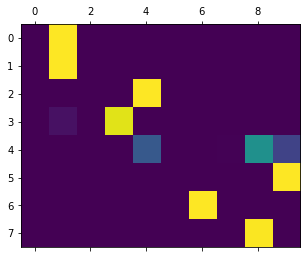

< 彼女 は 初心 者 だ 。  <EOS>

> i m fed up with her .
= 彼女 に は うんざり だ 。 


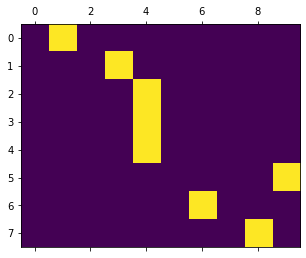

< 彼女 に は うんざり だ 。  <EOS>

> he s an author .
= 彼 は 作家 です 。 


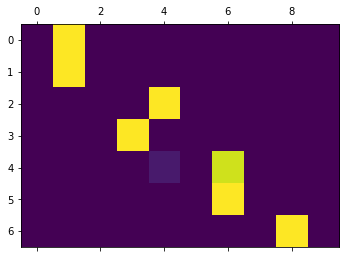

< 彼 は 作家 です 。  <EOS>

> he is a dramatist .
= 彼 は 劇作 家 で ある 。 


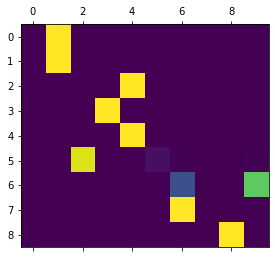

< 彼 は 劇作 家 で ある 。  <EOS>

> she is drawing a picture .
= 彼女 は 絵 を 描い て いる 。 


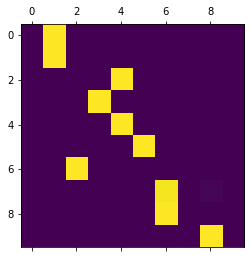

< 彼女 は 絵 を 描い て いる 。  <EOS>

> i m so full .
= もう 満腹 です 。 


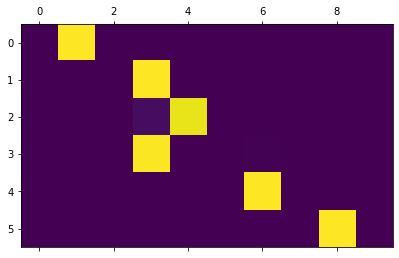

< もう 満腹 です 。  <EOS>

> he s just an ordinary man .
= 彼 は ただ の 凡人 です 。 


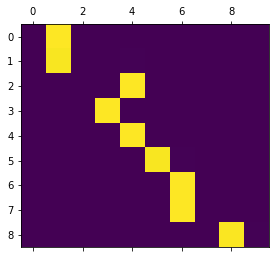

< 彼 は 単なる の 男性 です 。  <EOS>

> he is a good man at heart .
= 彼 は 根 は いい 人 だ 。 


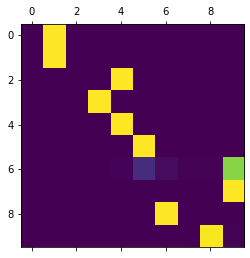

< 彼 は 根 は いい 人 だ 。  <EOS>

> i m a citizen of the world .
= 私 は 世界 市民 で ある 。 


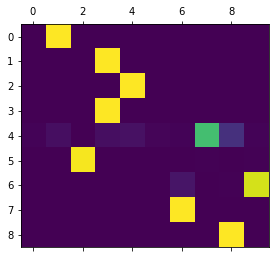

< 私 は 世界 市民 で ある 。  <EOS>



In [10]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad(): #勾配計算しないモード
        input_tensor = tensorFromSentence(input_lang, sentence) #入力文をID列のテンソルにする
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden() #エンコーダーの隠れ状態初期化
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device) #エンコーダーの出力記録領域を初期化
        for ei in range(input_length): #入力単語数だけ、ループを回す
            encoder_output, encoder_hidden = encoder(input_tensor[ei],  encoder_hidden) #エンコーダーで隠れ状態を更新
            encoder_outputs[ei] += encoder_output[0, 0] #出力を保存
        decoder_input = torch.tensor([[SOS_token]], device=device)  # # デコーダーの最初の入力に文頭マークを設定
        decoder_hidden = encoder_hidden #エンコーダーの出力をデコーダーの隠れ状態の初期値とする
        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)
        for di in range(max_length): #文末を予測するまで、ループ
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs) #デコーダーで次の単語を予測し、隠れ状態更新
            decoder_attentions[di] = decoder_attention.data #後で表示したいときのため保存
            topv, topi = decoder_output.data.topk(1) #次に来る予測単語を取り出す
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>') #文末を予測したら終了
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()]) #予測単語を出力単語リストに追加
            decoder_input = topi.squeeze().detach() #デコーダへの入力として、今得た予測単語を設定
        return decoded_words, decoder_attentions[:di + 1]

def evaluateRandomly(encoder, decoder, n=10): #ランダムに10個翻訳させる
    for i in range(n):
        pair = random.choice(pairs) 
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        plt.matshow(attentions.numpy())
        plt.show(block=False)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')


hidden_size = 256
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)
learning_rate=0.01
encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
#エンコーダー、デコーダーのパラメータを保存ファイルからロード
m = torch.load('seq2seq_a.pt')
encoder.load_state_dict(m['enc'])
decoder.load_state_dict(m['dec'])
encoder_optimizer.load_state_dict(m['eopt'])
decoder_optimizer.load_state_dict(m['dopt'])
evaluateRandomly(encoder, decoder,30)